# One Hidden Layer Neural Network

We have seen how tensors work so far and how "autograd" is our handy gradient calculator. Let's try using the same toy measurement dataset from the previous "02" notebook with the simplest neural network. That is, a linear model single hidden layer with activation. We will use a `tanh` activation function since it is easy to understand.

Thinking about basis functions, linear combinations of activation functions can approximate any function.

How about trying a different optimizer like stochastic gradient descent (SGD). Before training our network, let's split the data into a training and validation set.

In [45]:
%matplotlib inline

In [46]:
from collections import OrderedDict, Counter
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

Load the data and convert them to column vectors/tensors

In [47]:
# Known Celsius temperature
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_c = torch.tensor(t_c).unsqueeze(1)

# Unknown temperature
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u).unsqueeze(1)

Split into training and validation sets.

In [48]:
n_samples = t_u.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8,  0, 10,  4,  6,  9,  1,  3]), tensor([2, 5, 7]))

In [49]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

Redefine the training loop method to include a generalized `torch.nn.Module` model and loss function.

In [50]:
def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    t_u_train,
    t_u_val,
    t_c_train,
    t_c_val
):
    """Training loop for toy temperature data using an neural network module

    Parameters
    ----------
    n_epochs : int
        Number of iterations
    optimizer : torch.optim.Optimizer
        Optimizer class
    t_u_train : torch.Tensor
        Unknown temperature tensor for training
    t_u_val : torch.Tensor
        Target known temperature tensor for validation
    t_c_train : torch.Tensor
        Known temperature tensor for training
    t_c_val : torch.Tensor
        Known temperature tensor for validation
    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch < 5 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


Now let's define a neural network with named layers to help elucidate the functionality.

The number of nodes is an "art" and depends on the application. As we are using a simple NN model, the number of parameters does not need to be large. So let's pick 10. The optimizer will be SGD this time.

In [51]:
n_nodes = 10

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),  # The Linear method required args are the number of input features, output features
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_u_train,
    t_u_val = t_u_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 196.0588, Validation loss 89.7455
Epoch 2, Training loss 190.7498, Validation loss 87.1950
Epoch 3, Training loss 185.6710, Validation loss 84.8136
Epoch 4, Training loss 180.8124, Validation loss 82.5929
Epoch 1000, Training loss 74.0271, Validation loss 94.3523
Epoch 2000, Training loss 74.0217, Validation loss 94.2235
Epoch 3000, Training loss 74.0273, Validation loss 94.3704
Epoch 4000, Training loss 74.0273, Validation loss 94.3702
Epoch 5000, Training loss 74.0273, Validation loss 94.3699
output tensor([[12.0625],
        [12.0625],
        [12.0617]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [ 8.],
        [-4.]])
hidden tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [ 8.9347e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.5730e-04],
        [ 0.0000e+00],
        [ 9.4761e-04],
        [ 0.0000e+00]])


The training and validation sets are small, so it is hard to gauge the convergence. Let's plot it

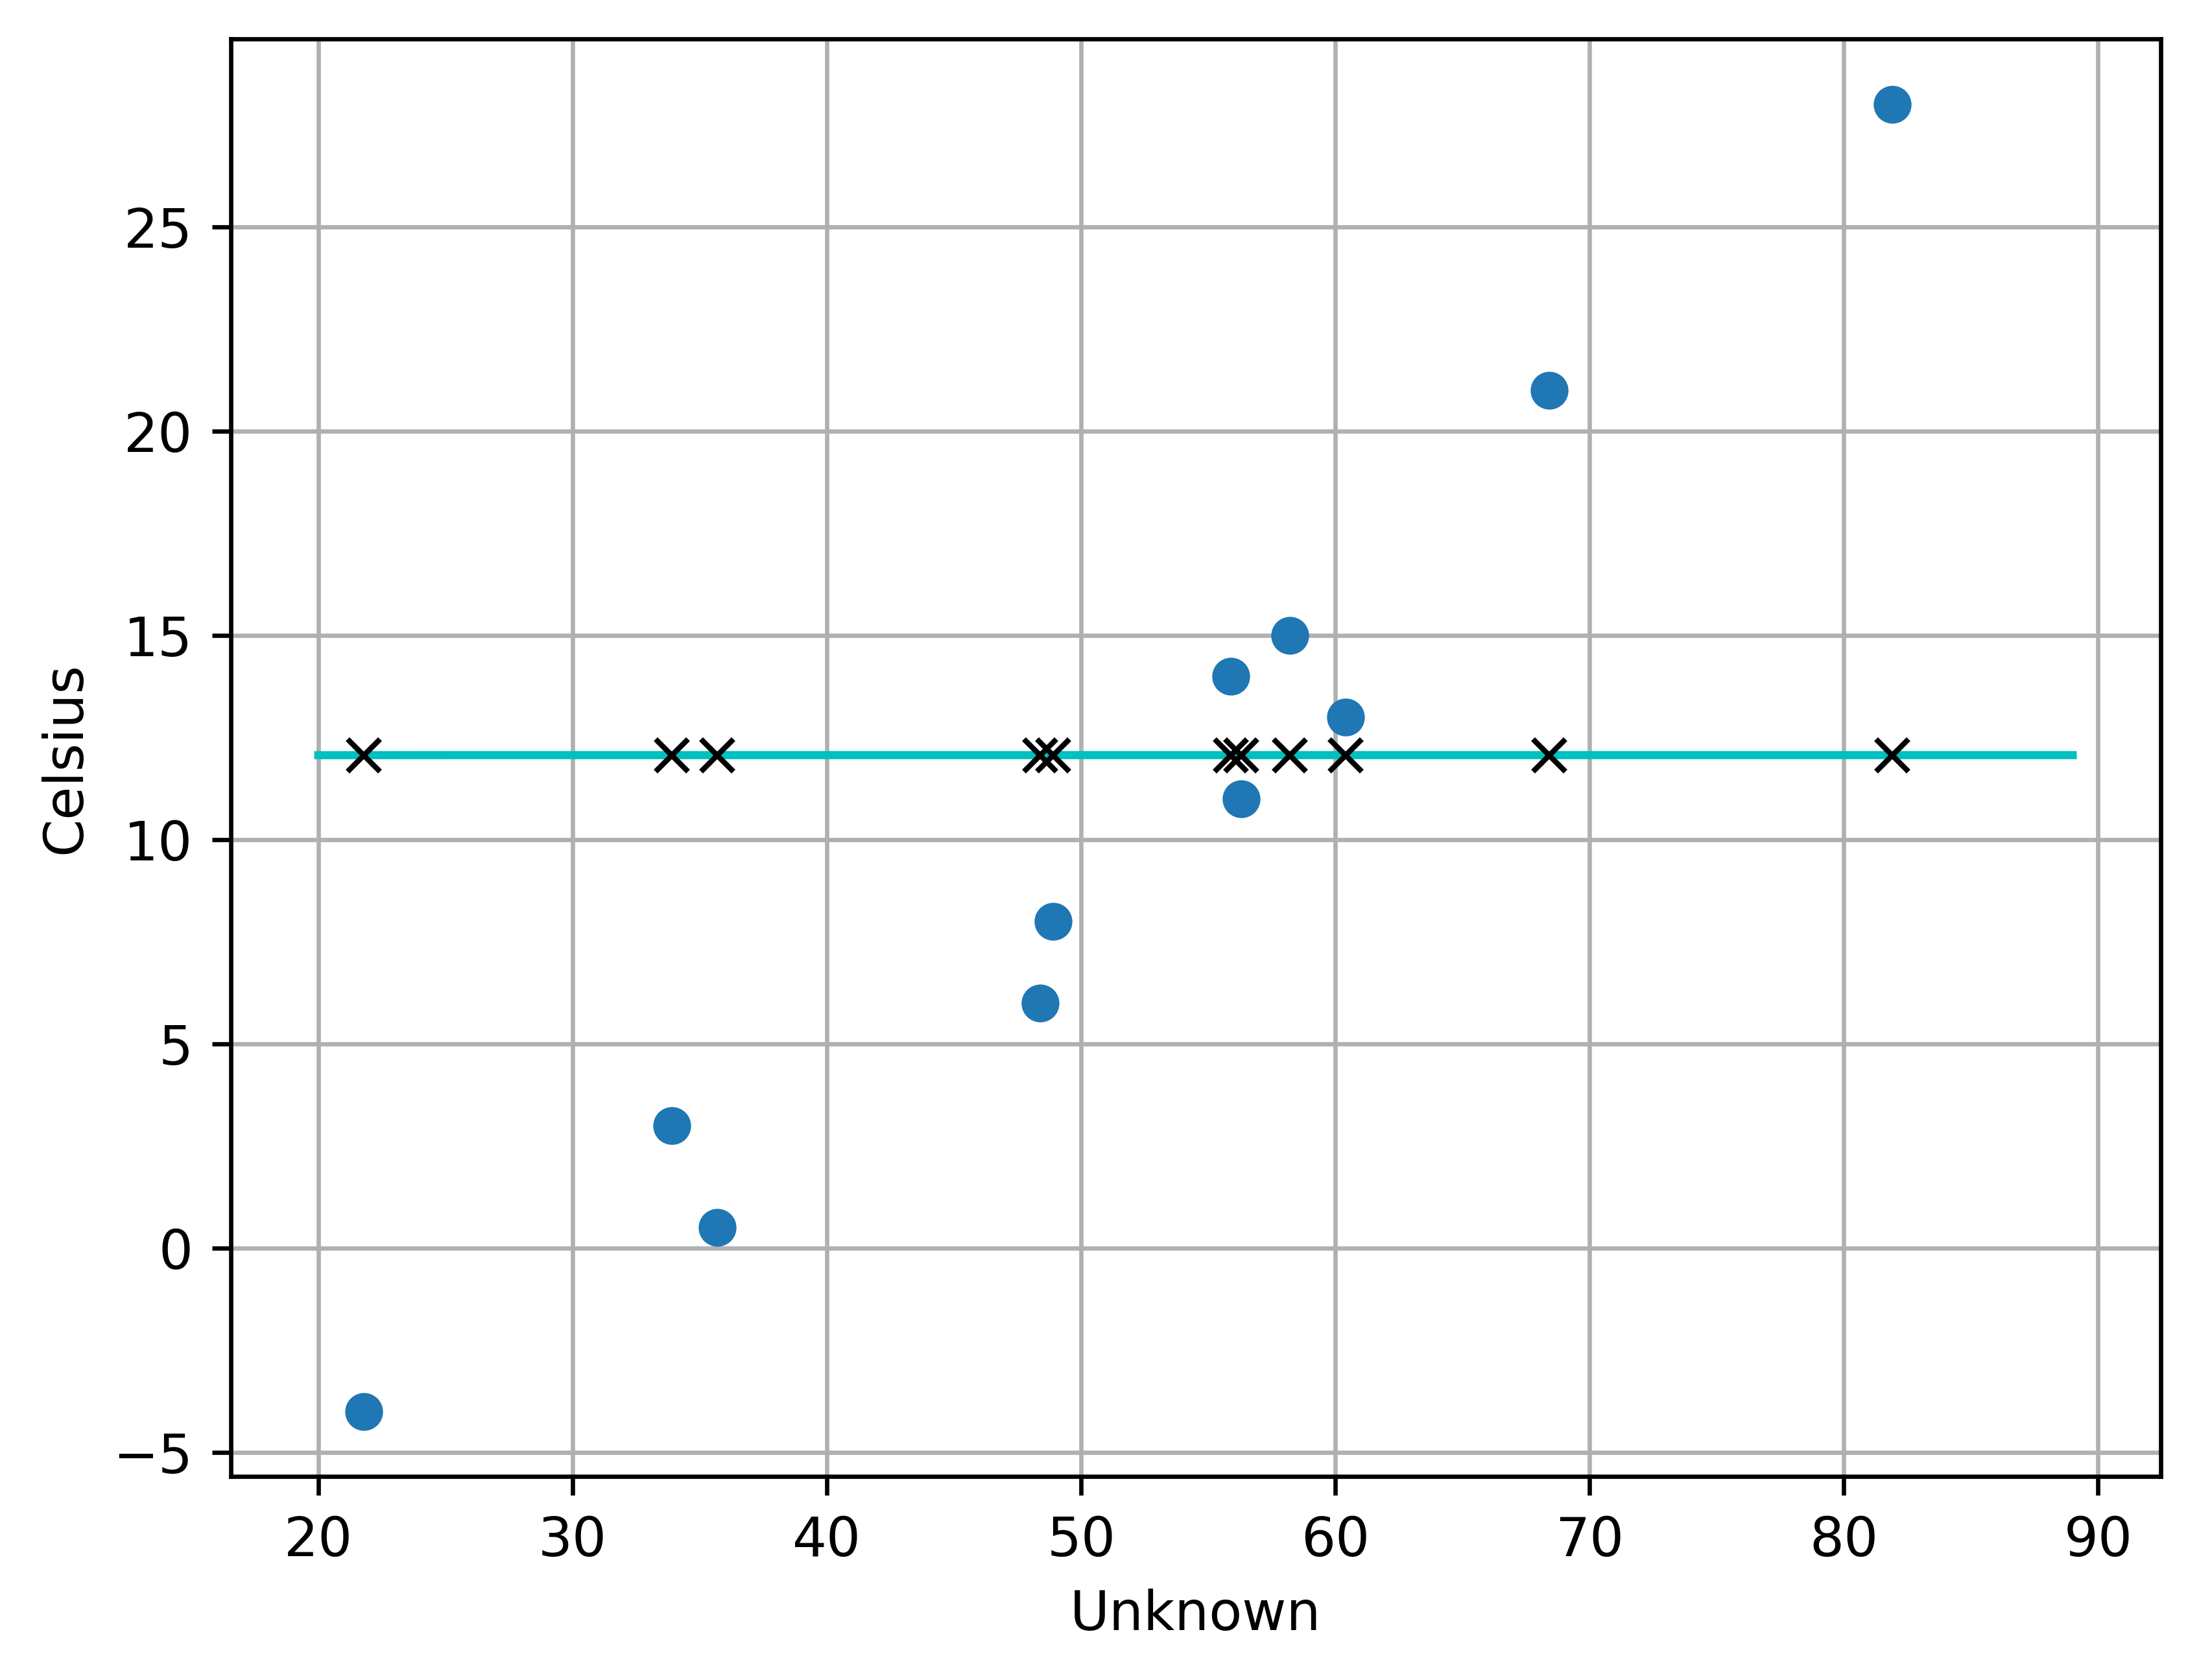

In [52]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(t_u).detach().numpy(), 'kx')

__WOAH__. The model did a awful job. Why is that?

Because we did not normalize the data range. The activation function `tanh` is saturated well above 10.

Let's normalize our unknown temperature measurements to a magnitude that is similar to $O(1)$

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 207.4973, Validation loss 95.2804
Epoch 2, Training loss 201.8004, Validation loss 92.3438
Epoch 3, Training loss 196.3413, Validation loss 89.5742
Epoch 4, Training loss 191.1150, Validation loss 86.9625
Epoch 1000, Training loss 5.3166, Validation loss 0.5433
Epoch 2000, Training loss 4.1050, Validation loss 0.2920
Epoch 3000, Training loss 2.7946, Validation loss 0.6263
Epoch 4000, Training loss 2.2759, Validation loss 1.4833
Epoch 5000, Training loss 2.1191, Validation loss 2.0905
output tensor([[12.4540],
        [ 6.8770],
        [-2.1782]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [ 8.],
        [-4.]])
hidden tensor([[-1.1873e+01],
        [ 1.3092e+01],
        [-1.0868e+01],
        [ 3.0331e-01],
        [ 6.3735e+00],
 

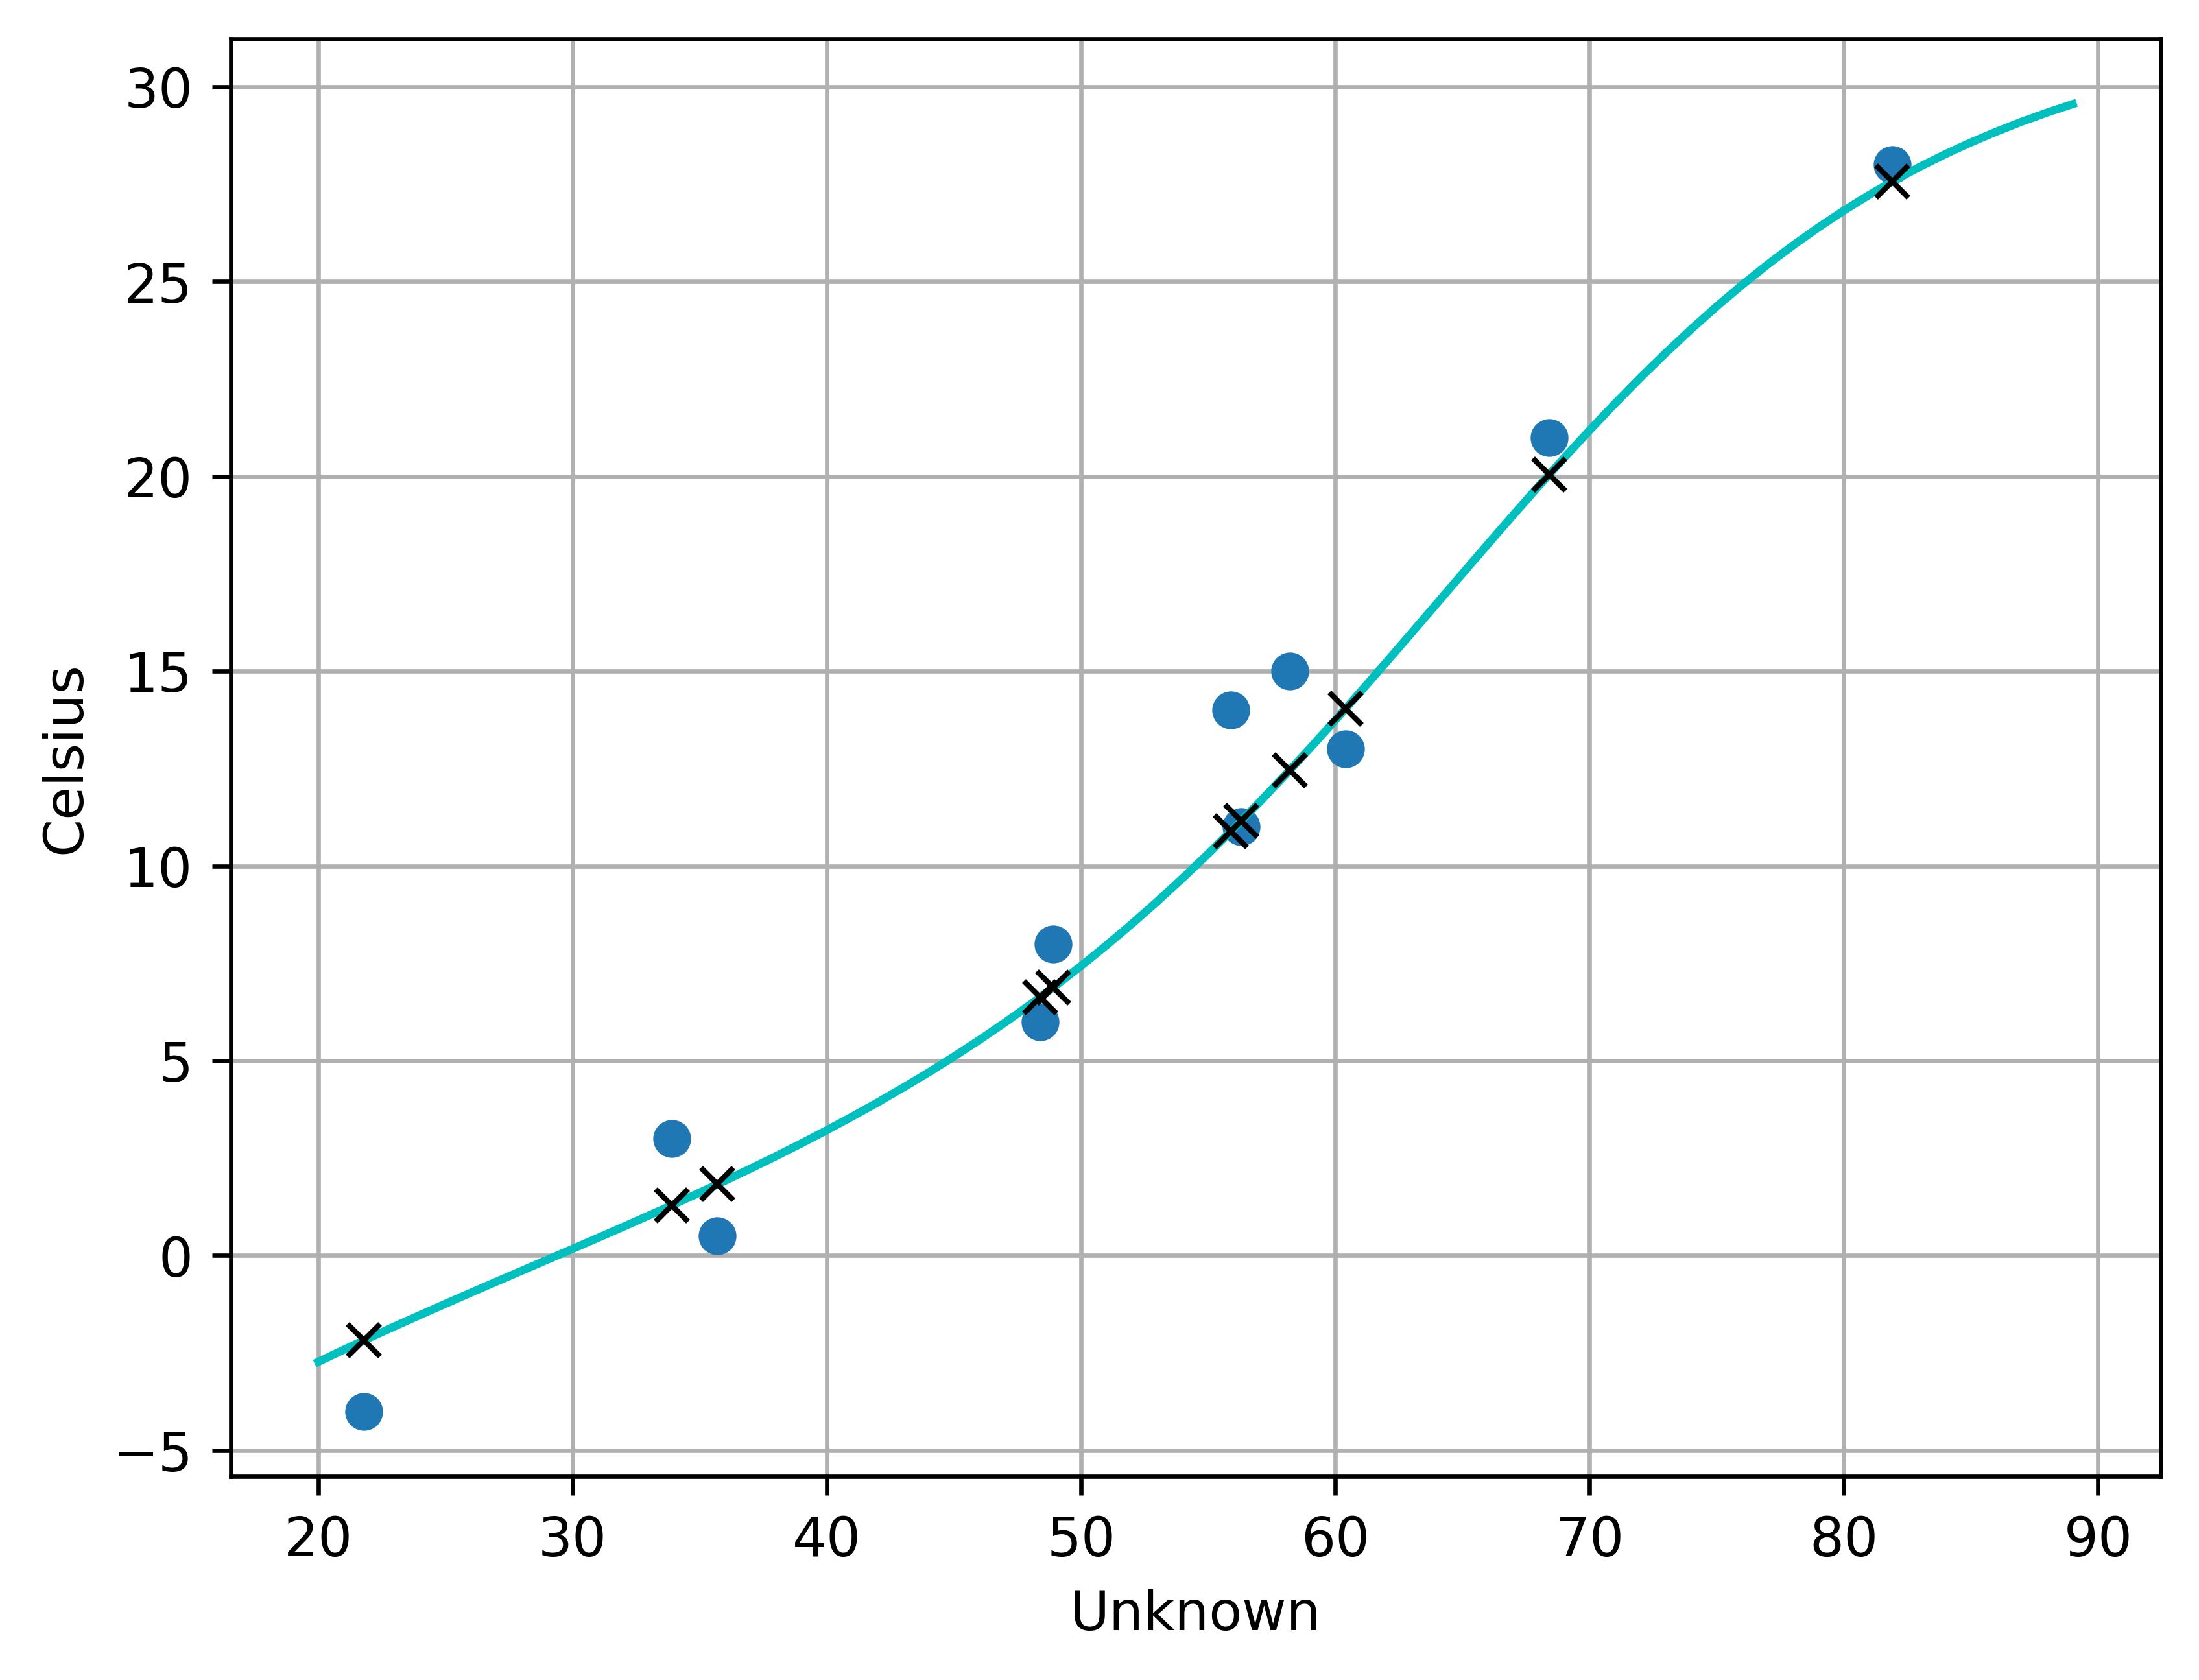

In [53]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Much better! The crude "normalization" above rescales the range of the input. However, we observe overfitting at the extremum points.

A better approach is to set the population with mean zero and standard deviation of 1.

In [54]:
t_u_mean, t_u_std = torch.mean(t_u.squeeze()), torch.mean(t_u.squeeze())
t_un_train = (t_u_train - t_u_mean) / t_u_std
t_un_val = (t_u_val - t_u_mean) / t_u_std

In [55]:
t_un_train.shape

torch.Size([8, 1])

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=10, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=10, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 224.1302, Validation loss 103.9927
Epoch 2, Training loss 221.9894, Validation loss 102.8620
Epoch 3, Training loss 219.8904, Validation loss 101.7576
Epoch 4, Training loss 217.8305, Validation loss 100.6781
Epoch 1000, Training loss 4.2420, Validation loss 0.4977
Epoch 2000, Training loss 2.1275, Validation loss 2.0036
Epoch 3000, Training loss 1.9569, Validation loss 3.0648
Epoch 4000, Training loss 1.9393, Validation loss 3.5567
Epoch 5000, Training loss 1.9343, Validation loss 3.8182
output tensor([[12.9190],
        [ 7.1277],
        [-1.4773]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [ 8.],
        [-4.]])
hidden tensor([[ 0.0031],
        [ 0.0023],
        [-0.0125],
        [ 0.0112],
        [ 0.0025],
        [ 0.0112]

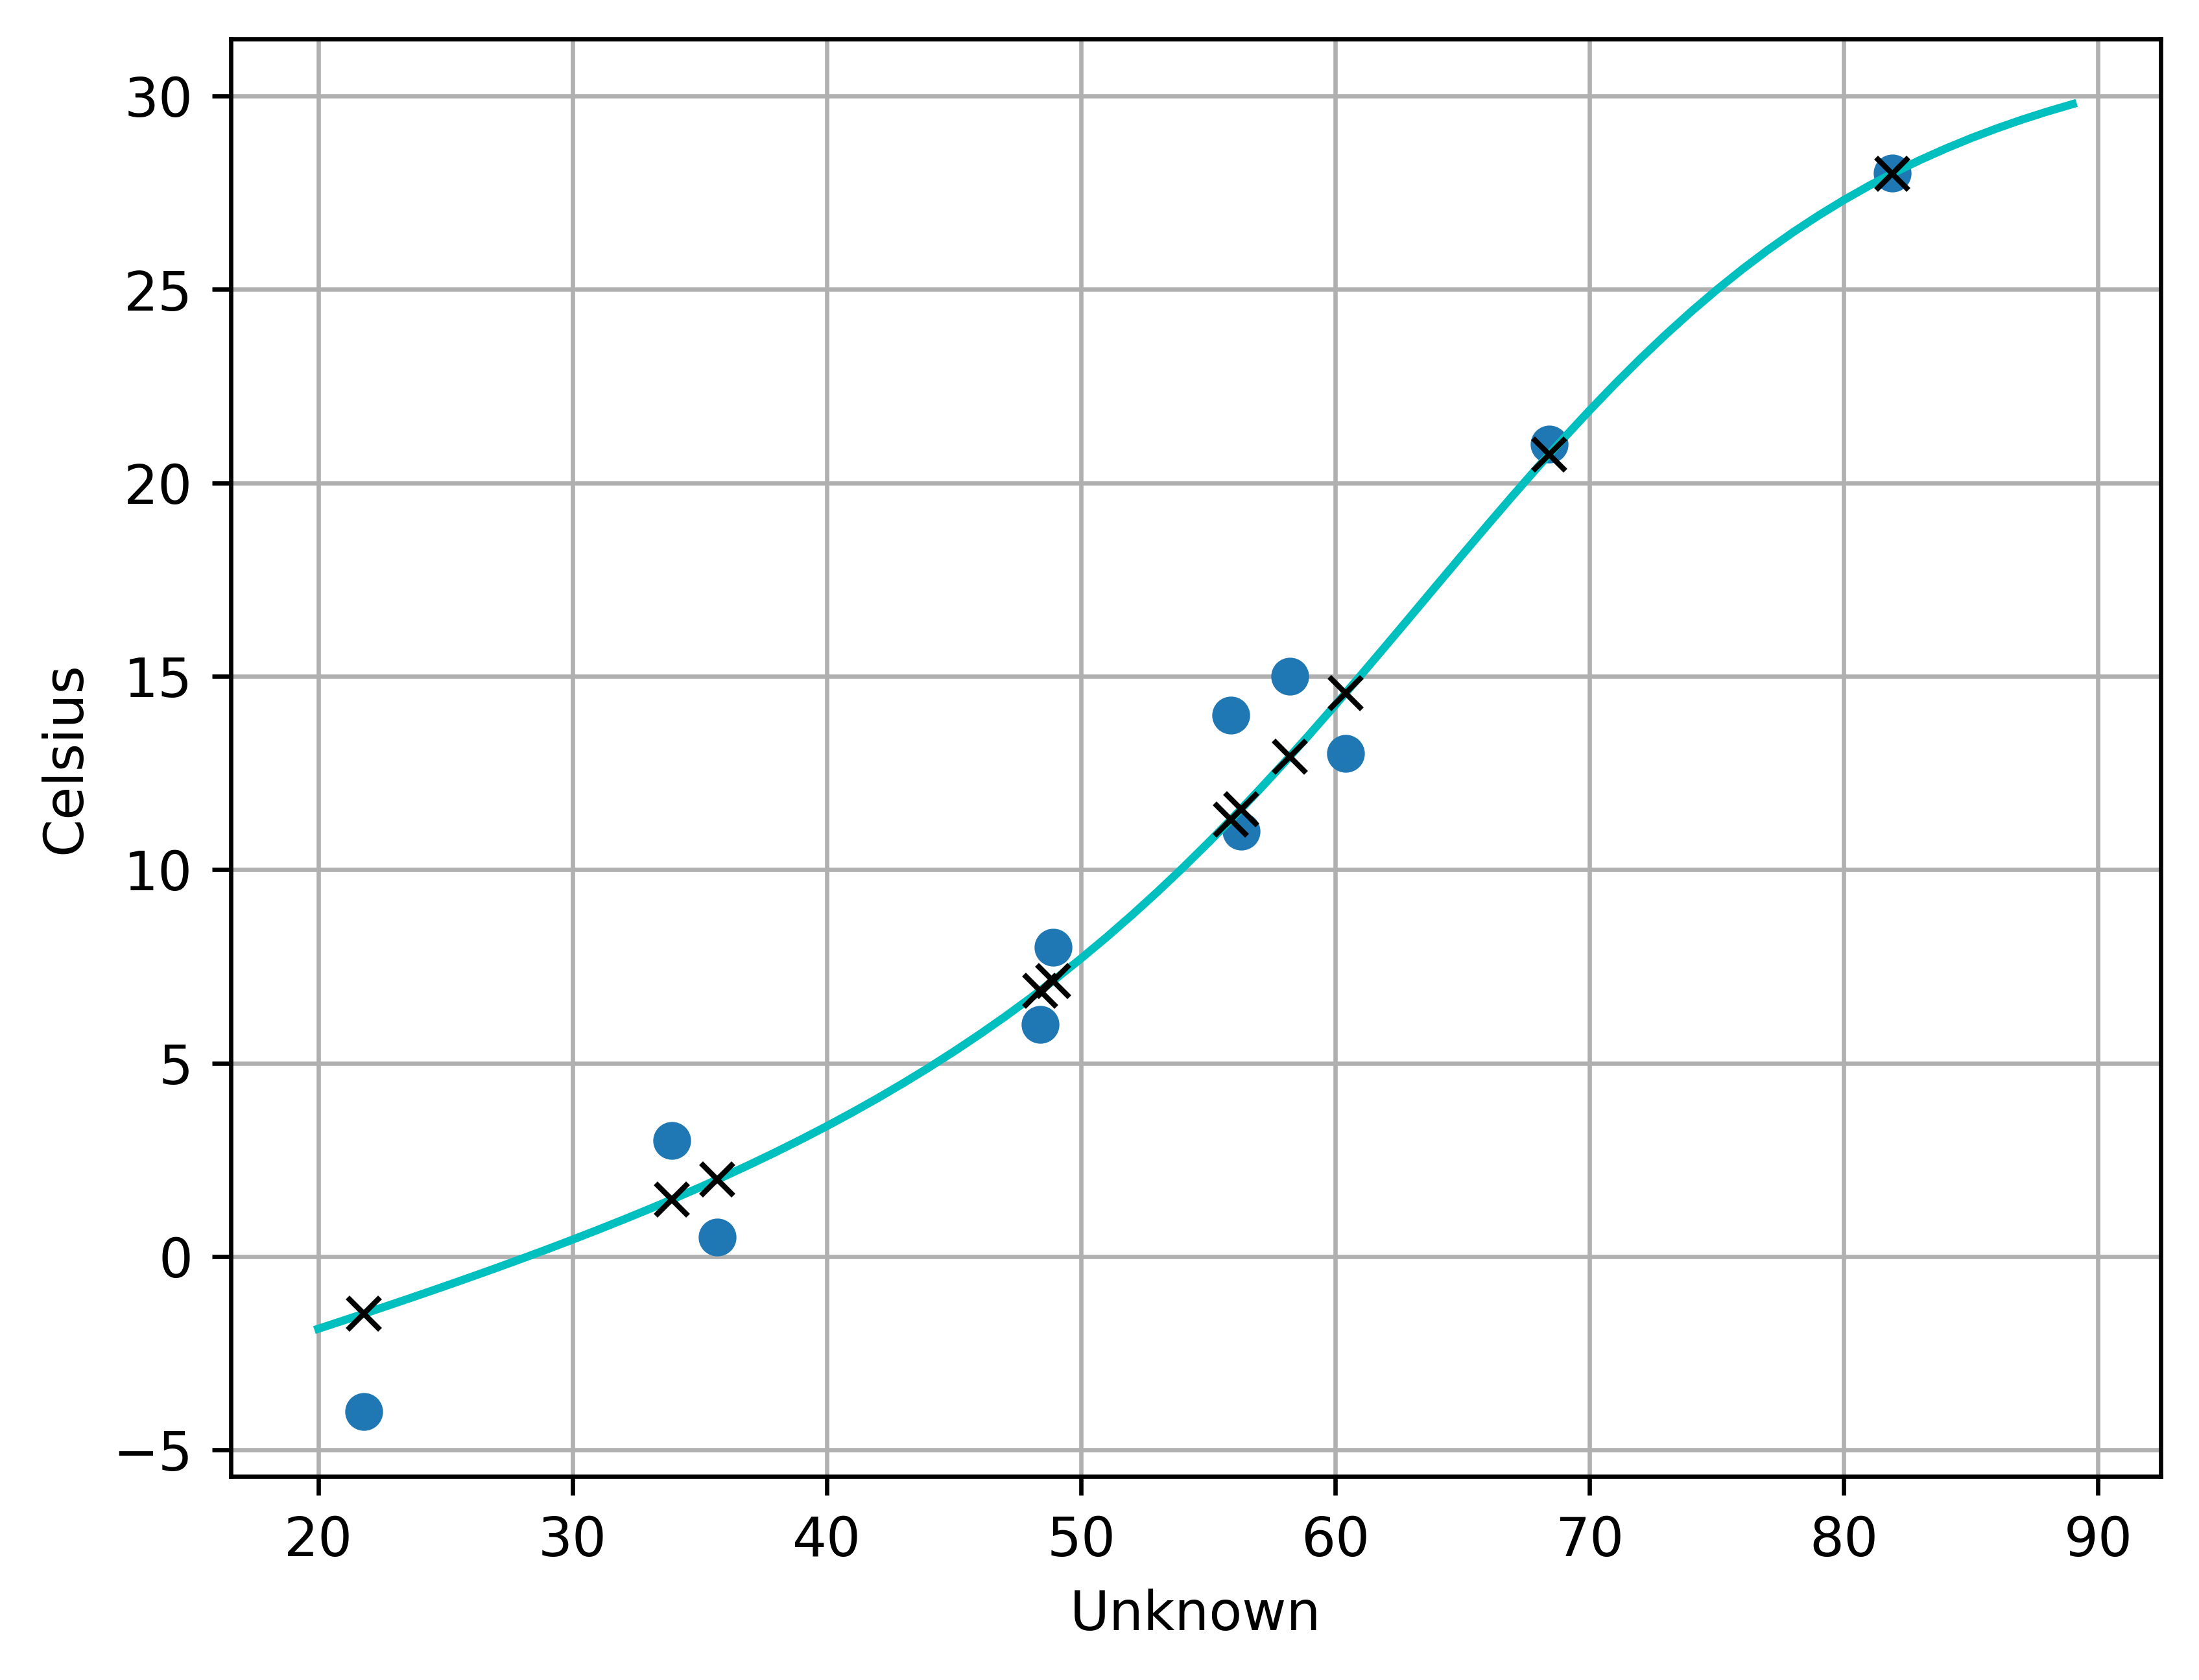

In [56]:

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)

# Show the inputs
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# Show the model
plt.plot(t_range.numpy(), seq_model((t_range - t_u_mean) / t_u_std).detach().numpy(), 'c-')
# Show where the model coincides in the horizontal axis
plt.plot(t_u.numpy(), seq_model((t_u - t_u_mean) / t_u_std).detach().numpy(), 'kx')

Intuitively, we should feel that using a linear model is better here than using a NN. Simply put, we are overfitting using such a function. We could play with different activation functions, but that still is not useful.

We can see that the advantage and flexibility of NNs: model _almost_ any complicated function.

Let's go back to the Wine Quality data and see what accuracy we can achieve.

In [57]:
wine_file = Path("winequality-white.csv")
wine_df: pd.DataFrame = pd.read_csv(
    os.fspath(wine_file),
    sep=";",
    header=0,
    dtype=np.float32,
)

wine_t: torch.Tensor = torch.from_numpy(wine_df.to_numpy())
wine_data_t: torch.Tensor = wine_t[:, :-1]
wine_target_t: torch.Tensor = wine_t[:, -1].long()

wine_target_1h_t: torch.Tensor = torch.zeros(wine_target_t.shape[0], 11)
wine_target_1h_t.scatter_(1, wine_target_t.unsqueeze(1), 1.0)

# Normalize the data
wine_data_norm_t: torch.Tensor = torch.zeros(wine_data_t.shape, dtype=torch.float32)
column_means_t: torch.Tensor = torch.mean(wine_data_t, dim=1)
column_stds_t: torch.Tensor = torch.std(wine_data_t, dim=1)

for col in range(wine_data_t.shape[1]):
    wine_data_mean, wine_data_std = column_means_t[col], column_stds_t[col]
    wine_data_norm_t[:, col] = (wine_data_t[:, col] - wine_data_mean) / wine_data_std


Split between training and validation

In [58]:
n_samples = wine_data_norm_t.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

wine_data_train_t = wine_data_norm_t[train_indices]
wine_data_val_t = wine_data_norm_t[val_indices]

wine_target_train_t = wine_target_1h_t[train_indices]
wine_target_val_t = wine_target_1h_t[val_indices]

# Reshape the input and output tensors so that there are B batches of 1xC column tensor
wine_data_train_t.unsqueeze_(1)
wine_data_val_t.unsqueeze_(1)
wine_target_train_t.unsqueeze_(1)
wine_target_val_t.unsqueeze_(1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [59]:
len(wine_df.columns), wine_data_train_t.shape, wine_target_train_t.shape

(12, torch.Size([3233, 1, 11]), torch.Size([3233, 1, 11]))

It is a coincidence that there are 11 columns in both data and target. There are 12 columns in the file and we are using one of them as the target. The quality target is bounded between 0 and 10, being 11 total.

In [67]:
n_nodes = 10 * wine_data_train_t.shape[2]

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(wine_data_train_t.shape[2], n_nodes)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_nodes, wine_target_train_t.shape[2]))
]))

optimizer = optim.Adam(seq_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = loss_fn,
    t_u_train = wine_data_train_t,
    t_u_val = wine_data_val_t,
    t_c_train = wine_target_train_t,
    t_c_val = wine_target_val_t)

Epoch 1, Training loss 0.2100, Validation loss 0.2071
Epoch 2, Training loss 0.1776, Validation loss 0.1751
Epoch 3, Training loss 0.1509, Validation loss 0.1487
Epoch 4, Training loss 0.1291, Validation loss 0.1272
Epoch 1000, Training loss 0.0562, Validation loss 0.0562
Epoch 2000, Training loss 0.0558, Validation loss 0.0559
Epoch 3000, Training loss 0.0550, Validation loss 0.0551
Epoch 4000, Training loss 0.0543, Validation loss 0.0545
Epoch 5000, Training loss 0.0538, Validation loss 0.0540


OK. Looks like our model did not quite converge, but that is OK. What are the results?

In [72]:
first_val_results = seq_model(wine_data_val_t[0])
first_val_results

tensor([[ 0.0012,  0.0014,  0.0024, -0.0071,  0.0380,  0.5118,  0.3462,  0.0959,
          0.0330,  0.0019, -0.0070]], grad_fn=<AddmmBackward0>)

In [73]:
torch.sum(first_val_results)

tensor(1.0177, grad_fn=<SumBackward0>)

In [75]:
torch.argmax(first_val_results).item()

5

So it looks like the output is a set of "probabilities". Not quite as there are negative numbers. But taking the argmax returns the most-likely estimate.

In [61]:
# Prediction minus target counter
pred_target_diffs = [
    torch.argmax(seq_model(wine_data_val_t[i])).item()  # prediction
    - torch.argmax(wine_target_val_t[i]).item()         # taget
    for i in range(wine_data_val_t.shape[0])
]
counts = Counter(pred_target_diffs)

for diff, count in counts.items():
    per = count / wine_data_val_t.shape[0] * 100
    print(f"{'+' if diff >= 0 else ''}{diff} count = {count} ({per:.2f}%)")


+0 count = 873 (52.43%)
-1 count = 379 (22.76%)
+2 count = 26 (1.56%)
+1 count = 313 (18.80%)
-2 count = 59 (3.54%)
-3 count = 9 (0.54%)
+3 count = 6 (0.36%)


So about 51% of the time, we get the answer right, 43% is off by one, 6% off by two, <1% off by three. Not bad! I would say this is good in that the objective function mitigated $\pm1$ quality differences well.

Does a data visualization help with this?

Text(0, 0.5, 'Counts')

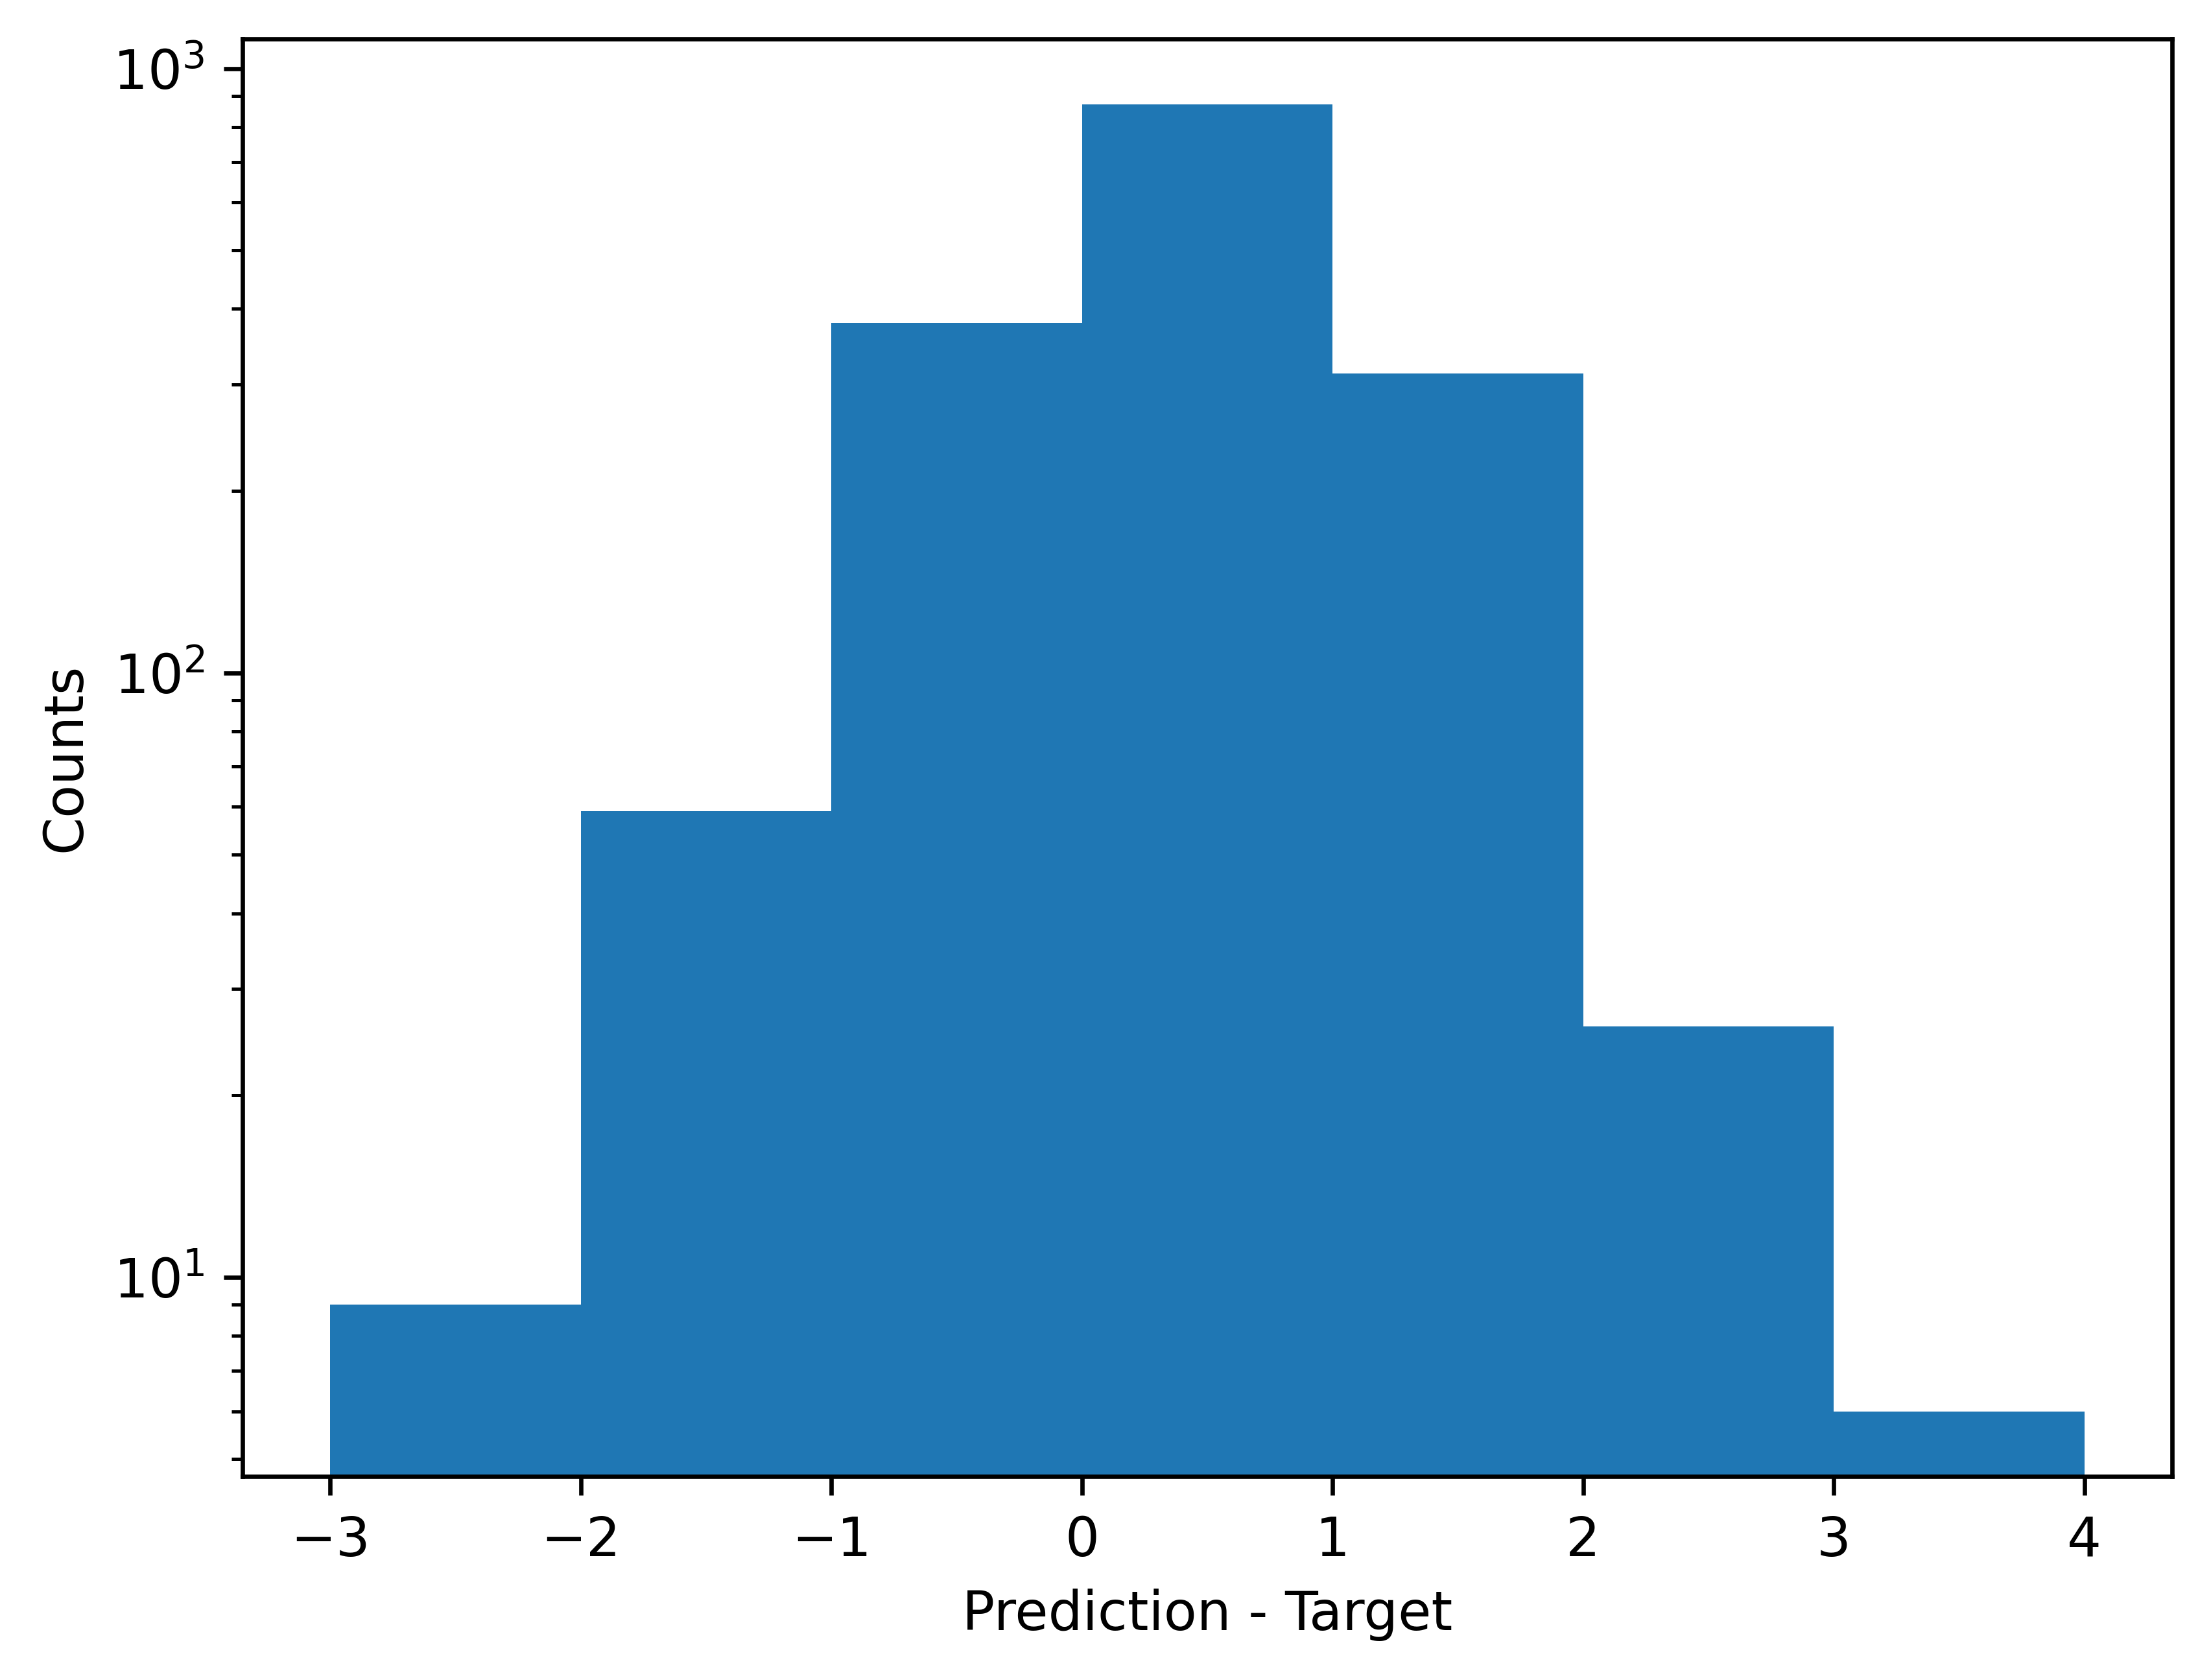

In [62]:
fig_hist, ax_hist = plt.subplots(dpi=600)

ax_hist: plt.Axes
bins = sorted(counts.keys())
bins.append(bins[-1]+1)
ax_hist.hist(
    pred_target_diffs,
    bins,
    log=True
)
ax_hist.set_xlabel("Prediction - Target")
ax_hist.set_ylabel("Counts")

Since the data is 11-dim, it is hard to plot the data versus target. But does this difference match the shape of the quality target data?

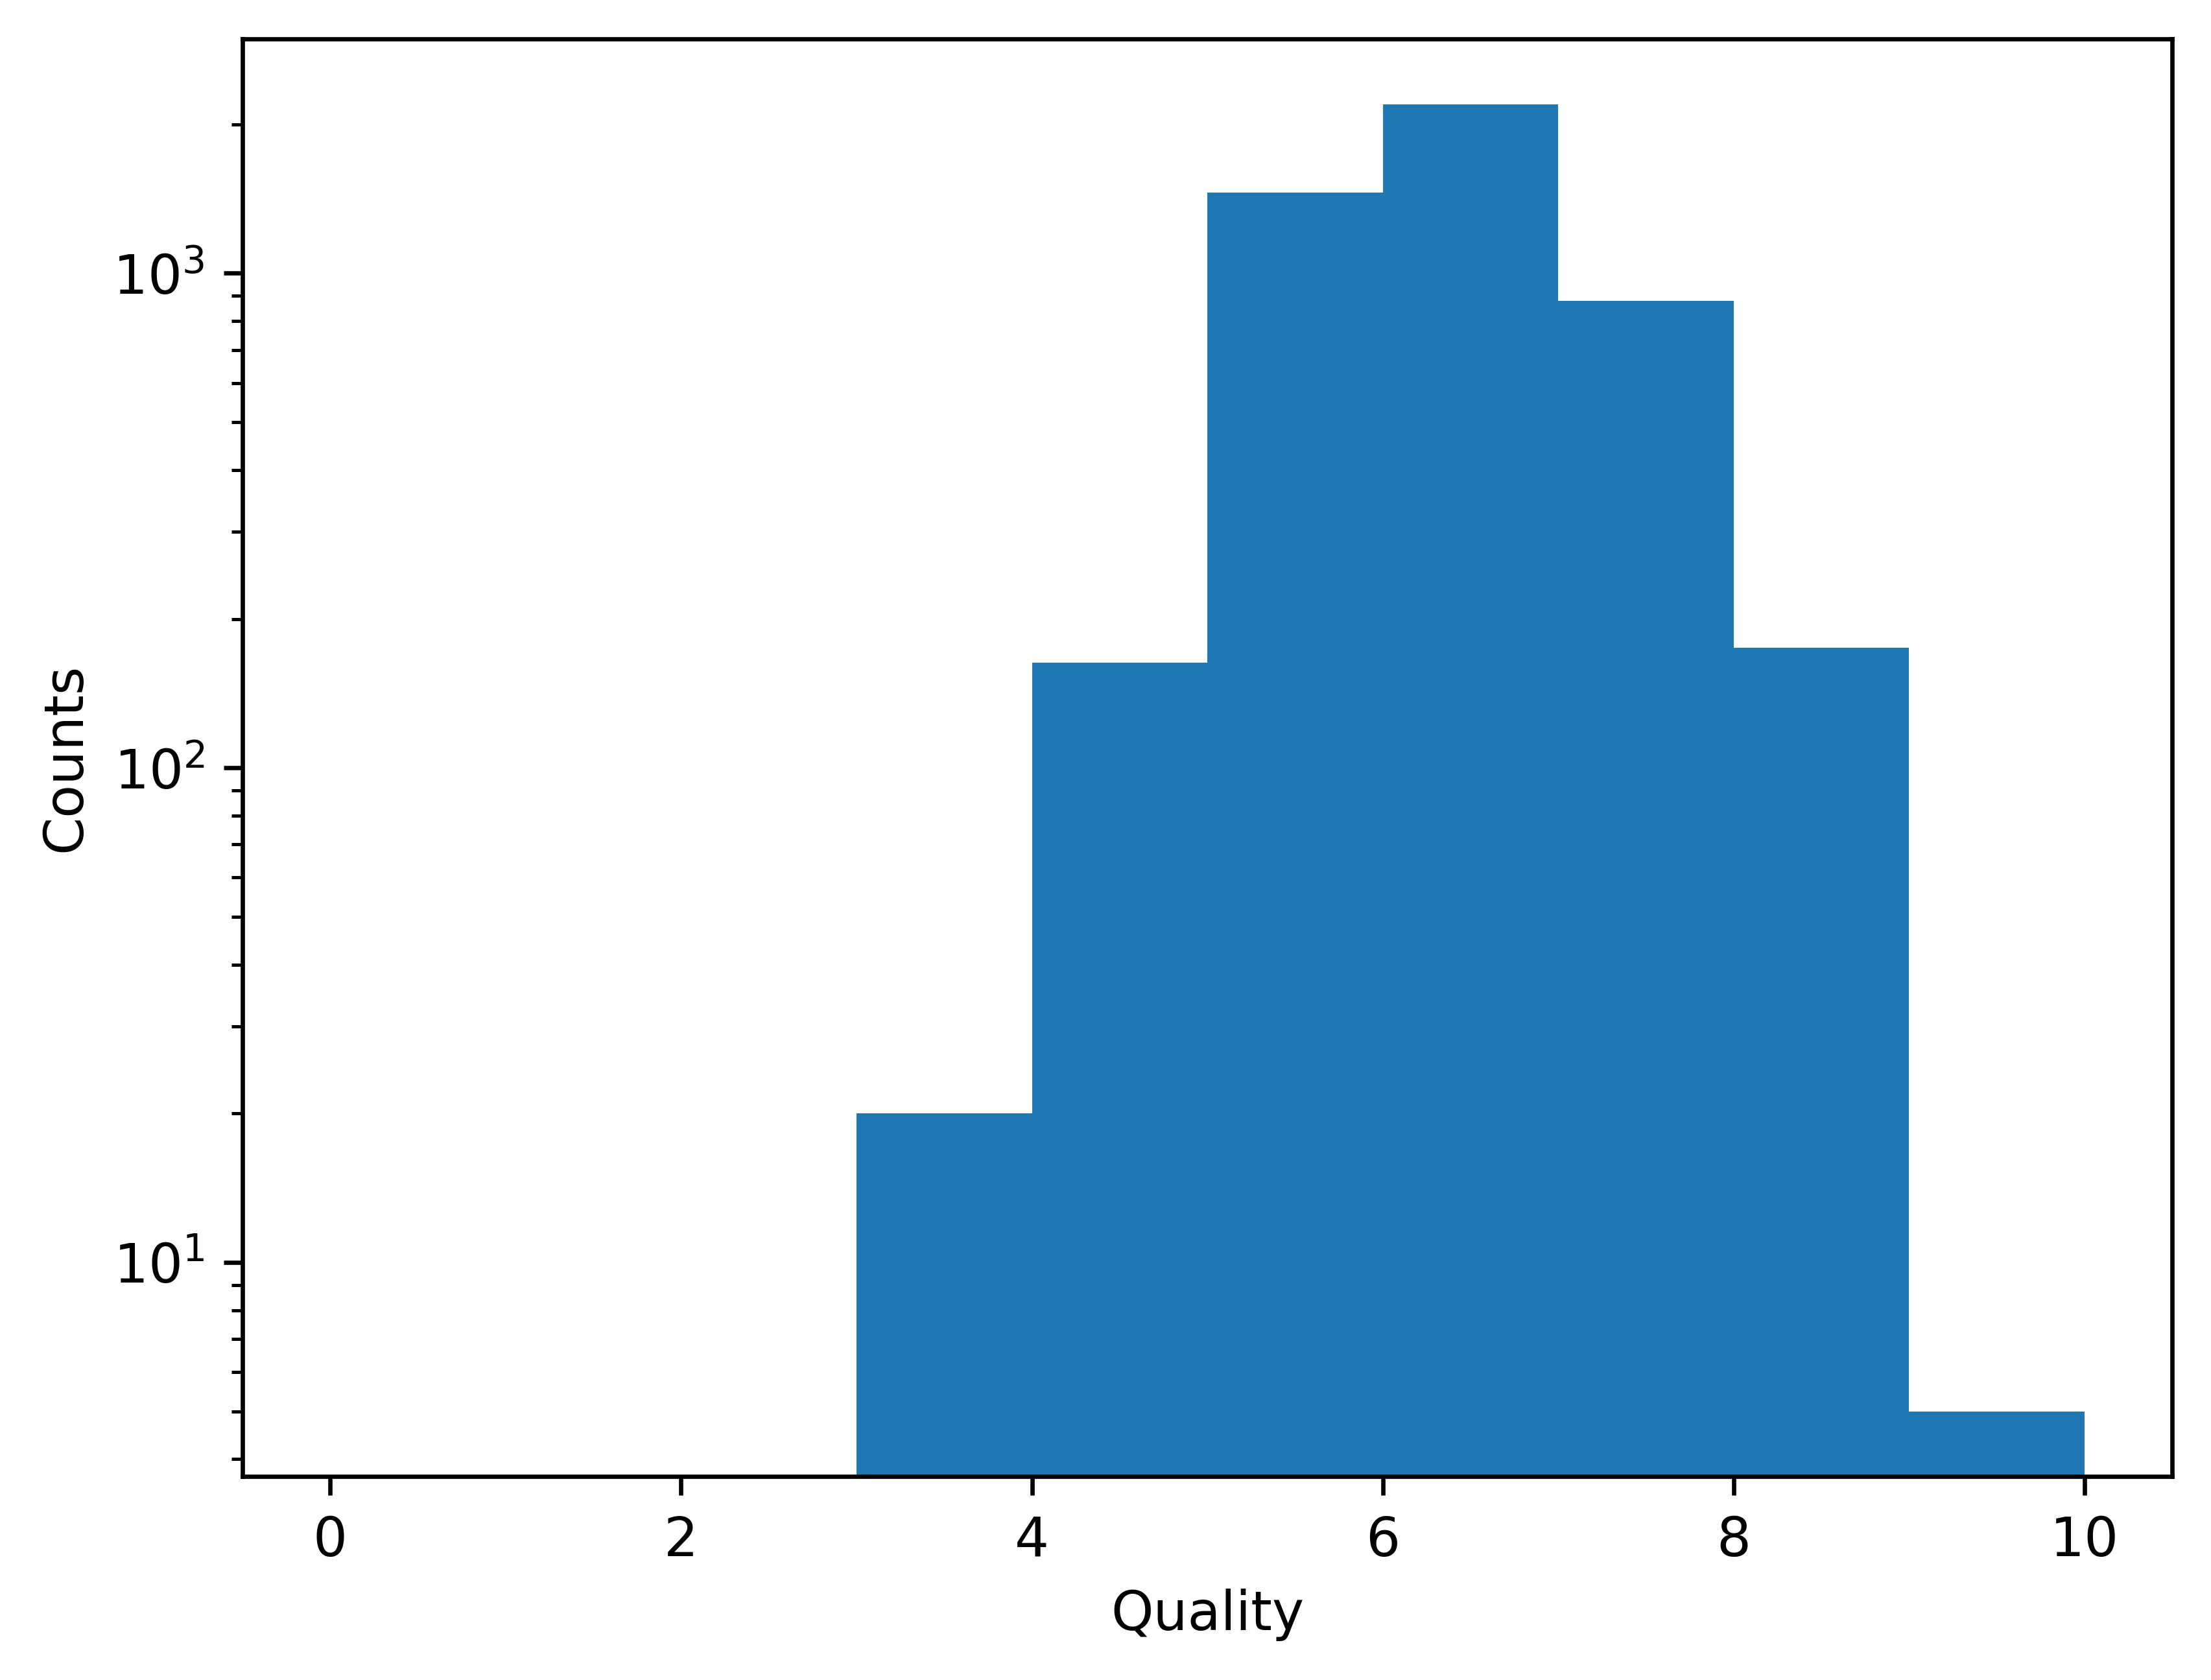

In [63]:
fig_qual, ax_qual = plt.subplots(dpi=600)

ax_qual: plt.Axes
bins = list(range(0, 11))
ax_qual.hist(
    wine_df.quality.to_numpy(),
    bins,
    log=True
)
ax_qual.set_xlabel("Quality")
ax_qual.set_ylabel("Counts")
plt.show(fig_qual)

Looks similar. We could perform a KS-test to compare the shapes, but this is academic.